# 对TS FACS数据的统计描述
原始计数数据，未经过预处理
* 1. 每个组织、每个细胞类型中的细胞数量
* 2. 验证asthma在单细胞数据基因中是否还能形成双峰曲线
* 3. 单细胞、asthma、网络重合基因的类别组成

In [1]:
import pandas as pd
import networkx as nx
import zipfile
import os
import scanpy as sc
import matplotlib.pyplot as plt
#战置全局字体大小为12
plt.rcParams['font.size'] = 14

import warnings
# 禁用所有警告
warnings.filterwarnings("ignore")

In [2]:
# 遍历文件夹中的指定格式的文件
def openFolderAll(folder_path,desired_extension):
    filelist = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and filename.endswith(desired_extension):
            filelist.append(file_path)
    return filelist

## 1. 每个组织、每个细胞类型中的细胞数量

In [ ]:
# 统计每个组织中各个细胞类型中细胞数量
## 解压所有的组织zip文件
rootpath = r"..\data\TS FACS"
# 替换为实际的ZIP文件路径和解压目标文件夹
zip_file_path = openFolderAll(rootpath,"zip")
print(zip_file_path)
for i in zip_file_path:
    # 解压ZIP文件
    with zipfile.ZipFile(i, 'r') as zip_ref:
        zip_ref.extractall(rootpath)

rootpath = r"..\data\TS FACS"
# 替换为实际的ZIP文件路径和解压目标文件夹
zip_file_path = openFolderAll(rootpath,"h5ad")
result_path = r"..\data\tissues-celltypes-cellnum.csv"
count = 0
for file_path in zip_file_path[0:2]:
    print(file_path.split("\\")[-1].split(".")[0])
    tissue = file_path.split("\\")[-1].split(".")[0]
    count+=1
    # 读取TS FACS单细胞数据
    annData = sc.read_h5ad(file_path)
    # 按照指定列进行分组
    obs_df = pd.DataFrame(annData.obs)
    grouped_adata = obs_df.groupby("cell_ontology_class")
    # 使用value_counts()方法计算每个分组中的细胞数量
    group_counts = obs_df["cell_ontology_class"].value_counts()
    # 按细胞数量逆序排列分组
    sorted_groups = group_counts.sort_values()
    result_tissue = [tissue] * len(sorted_groups)
    result_celltype = list(sorted_groups.index)
    result = pd.DataFrame([result_tissue,result_celltype,sorted_groups]).T
    result.columns = ["tissue","celltype","cellnum"]
    # 将 DataFrame 追加到文本文件，逐行写入
    if count == 1 :
        result.to_csv(result_path, index=False, header=False, mode='w')
    else:
        result.to_csv(result_path, index=False, header=False, mode='a')

In [2]:
# 读取组织-细胞类型细胞数量
tissue_ct_cellnum = pd.read_csv(r"E:\0_单细胞1\results\tissues-celltypes-cellnum-new.csv")
# 总细胞数量 ： 483152
sum(tissue_ct_cellnum["cellnum"])
# 组织中的细胞数量
tissue_cellnum = tissue_ct_cellnum.groupby('tissue')["cellnum"].sum()
tissue_cellnum

In [16]:
# 细胞类型中的细胞数量
ct_cellnum = tissue_ct_cellnum.groupby('celltype')
keylist = []
valuelist = []
tissuenumlist = []
cellnumsumlist = []
cellnumlist = []
for key,value in ct_cellnum:
    keylist.append(key)
    valuelist.append(value["tissue"].values)
    tissuenumlist.append(len(value["tissue"]))
    cellnumlist.append(value["cellnum"].values)
    cellnumsumlist.append(value["cellnum"].sum())
ct_cellnum_df = pd.DataFrame([keylist,valuelist,cellnumlist,tissuenumlist,cellnumsumlist]).T
ct_cellnum_df.to_csv("temp.csv")


## 验证asthma在单细胞数据基因中是否还能形成双峰曲线

In [3]:
'''读取背景网络'''
def openPPI(filename):
    '''
        打开PPI
        文件格式 gene1_name gene1_id gene2_name gene2_id
        返回值：网络[节点是gene name]
    '''
    G = nx.Graph()
    a=open(filename,"r")
    next(a)

    for i in a:
        n=i.strip().split("\t")
        G.add_edge(n[0],n[3])
        G.add_node(n[0])
        G.add_node(n[3])
    a.close()
    return G
G = openPPI(r"..\data\network(process_id).txt")

In [13]:
# 计算最大连通分支
def Lcc(G,genename):
    '''
        输入图网络和一个列表，计算最大连通分支lcc
        G：图，这里图中的节点是基因name
        genename：用于计算lcc的genename列表
    '''

    g = nx.subgraph(G,genename)
    if len(genename)==0:
        largest = 0
        l = []
        return l,largest
    else:
        try:
            l = max(nx.connected_components(g),key=len)  #如果随机选取的gene没有连通分支的话，会报错，添加判断条件
            largest = len(l)     #最大联通分支
        except ValueError as e:
            l = genename[0]    # 假设genename列表中的第一个基因为最大连通分支
            largest = 1        #设置最大联通分支数为1
        return list(l),largest


In [14]:
import random
import numpy as np

def Lcc_mean(g,genelist,ran):
    '''
    每次从网络G的所有基因中随机选择genelist数量的gene，计算均值和标准差
    g:背景网络
    genelist：
    ran：随机次数
    返回：表达值之和、表达值均值的多次随机的均值和标准差
    '''

    all_genes = g.nodes()  # 背景网络中的gene

    #做随机实验
    l_list = []         #lcc列表
    for j in range(ran):
        black_nodes = random.sample(all_genes,len(genelist))
        l,largest_ran = Lcc(g,black_nodes)

        l_list.append(largest_ran)

    #计算lcczscore
    lcc_mean = np.mean(l_list)
    lcc_std  = np.std(l_list)

    return lcc_mean,lcc_std


In [15]:
# 计算lcczscore
def lccZscore(Lcc,lcc_mean,lcc_std):
    if lcc_std == 0:
        zscore = 0
    else:
        zscore = (Lcc - lcc_mean)/lcc_std
        zscore = round(zscore,6)
    return zscore

In [16]:
file_path = r"E:\0_单细胞1\data\TS FACS\TS_Liver.h5ad"
annData = sc.read_h5ad(file_path)
## 基因
sc_gene = list(annData.var.index)  # 58870

In [17]:
## 哮喘基因
'''读取asthma gwas数据中所有基因'''
trait = pd.read_csv(r"E:\0_单细胞1\data\poly_posterior_prior_gene_new\29_new.txt",sep = "\t")
trait_gene = list(set(list(trait["gene name"])))   # 性状相关基因 12676

# gene-pip排序
grouped_df = trait.groupby('gene name').sum()['posterior']
grouped_dfsorted = grouped_df.sort_values(ascending=False)
grouped_dfsorted = pd.DataFrame(grouped_dfsorted[1:]) #删除“-”
grouped_dfsorted["gene name"] = grouped_dfsorted.index


In [27]:
trait_sc_gene = set(sc_gene) & set(trait_gene)
# 提取asthma相关基因在单细胞中的基因
grouped_dfsorted_sc = grouped_dfsorted[grouped_dfsorted["gene name"].isin(trait_sc_gene)]

In [49]:
def samplePip(grouped_dfsorted):
    '''
    采样策略：
            [0~0.1:0.002)  100次
            [0.1~0.2:0.005)  50次
            [0.2~1:0.01)  80次
            [1~4.238)  全取  227次

    :param grouped_dfsorted:
    :return:  pip的分界线
    '''
    temp1 = [i*0.001 for i in range(0,100,1)]
    temp2 = [i*0.001+0.1 for i in range(0,100,2)]
    temp3 = [i*0.01 for i in range(20,100)]
    temp4 = sorted(list(set(grouped_dfsorted[grouped_dfsorted['posterior']>=1]['posterior'].sort_values())))
    temp5 = [max(grouped_dfsorted['posterior']) + 0.1]
    binspip = temp1 + temp2 + temp3 + temp4 + temp5
    return binspip

In [51]:
# 只选特定的一些点来计算
binspip = samplePip(grouped_dfsorted_sc)
grouped_dfsorted_sc['Category'] = pd.cut(grouped_dfsorted_sc['posterior'], bins=binspip, right=False)
grouped_dfsorted_sc['Left_Boundary'] = grouped_dfsorted_sc['Category'].apply(lambda x: x.left)
gene_df= grouped_dfsorted_sc.groupby('Left_Boundary')["gene name"].agg(list).reset_index()
gene_df_sorted = gene_df.iloc[::-1]

In [52]:
gene_df_sorted

,Left_Boundary,gene name
451,4.23276,[LPP]
450,3.89163,[IL33]
449,3.88521,[SMAD3]
448,3.19145,[IL4R]
447,3.08824,[BACH2]
...,...,...
4,0.00400,"[APOD, PSMC6, AC104653.1, CYP4F23P, HECA, RNF2..."
3,0.00300,"[NMB, AL353803.1, RNF214, APBA3, TTC22, SP3P, ..."
2,0.00200,"[BRAT1, ASB7, PHAX, MTFR2, KRT39, SFPQ, ZNF787..."
1,0.00100,"[CSTF1, APCDD1, MECR, C15orf61, KLHL24, CLCA4,..."


In [63]:
import time

genelist = []
result_list = []
ran = 50
# 构造背景网络：每次随机从背景网络与单细胞数据交集的网络中随机取相同数量的基因
singlecell_network_genelist = list(set(sc_gene) & set(G.nodes))
g = nx.subgraph(G,singlecell_network_genelist)

for i in range(len(gene_df_sorted)):
    genelist.extend(gene_df_sorted.iloc[i]["gene name"])
    l,lcc = Lcc(G,genelist)
    lcc_mean,lcc_std = Lcc_mean(g,genelist,ran)
    lcczscore = lccZscore(lcc,lcc_mean,lcc_std)
    result_list.append([gene_df_sorted.iloc[i]["Left_Boundary"],len(genelist),lcc,lcczscore])

    if i % 20 == 1:
        print(i,len(genelist),time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    if i == len(gene_df_sorted) - 1:
        print("Finish！！！",time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))

df_singcell = pd.DataFrame(result_list)
df_singcell.columns = ["pip","genenum","lcc","lcczscore"]

1 2 2024-01-08 21:12:21
21 22 2024-01-08 21:12:38
41 42 2024-01-08 21:12:56
61 62 2024-01-08 21:13:14
81 82 2024-01-08 21:13:32
101 102 2024-01-08 21:13:51
121 122 2024-01-08 21:14:10
141 142 2024-01-08 21:14:28
161 162 2024-01-08 21:14:47
181 182 2024-01-08 21:15:08
201 202 2024-01-08 21:15:29
221 222 2024-01-08 21:15:51
241 326 2024-01-08 21:16:13
261 524 2024-01-08 21:16:41
281 913 2024-01-08 21:17:13
301 1961 2024-01-08 21:17:59
321 2404 2024-01-08 21:19:01
341 3050 2024-01-08 21:20:18
361 3730 2024-01-08 21:21:56
381 4305 2024-01-08 21:23:44
401 5131 2024-01-08 21:25:51
421 6340 2024-01-08 21:28:24
441 8413 2024-01-08 21:31:53
Finish！！！ 2024-01-08 21:34:47


In [64]:
df_singcell.to_csv(r"E:\0_单细胞1\results\asthma-singcell-lcczscore.csv")
df_singcell

,pip,genenum,lcc,lcczscore
0,4.23276,1,1,0.000000
1,3.89163,2,1,0.000000
2,3.88521,3,1,0.000000
3,3.19145,4,1,-0.204124
4,3.08824,5,1,0.000000
...,...,...,...,...
447,0.00400,9552,9253,6.402686
448,0.00300,9769,9480,6.507482
449,0.00200,10102,9815,6.689405
450,0.00100,10465,10176,5.288364


In [87]:
'''
按照pip值可视化lcczscore
要求：
    2. 纵坐标
    3. 横坐标不均匀分布
'''

index1 = df_singcell[df_singcell["pip"] == 0].index[-1]   # 416
index2 = df_singcell[df_singcell["pip"] >= 0.1].index[-1]   # 326   50
index3 = df_singcell[df_singcell["pip"] >= 1].index[-1]  # 227   50
index4 = df_singcell[df_singcell["pip"] >= 2].index[-1] # 35   50

# 从 DataFrame 中等间隔均匀地取一定数量的数据
indices0 = np.linspace(0, index4, 50, dtype=int)
sampled_data0 = df_singcell.iloc[indices0]
# sampled_data0 = df_singcell.iloc[0:index4]
indices1 = np.linspace(index4 + 1, index3, 50, dtype=int)
sampled_data1 = df_singcell.iloc[indices1]
indices2 = np.linspace(index3 + 1, index2, 50, dtype=int)
sampled_data2 = df_singcell.iloc[indices2]
indices3 = np.linspace(index2 + 1, index1, 50, dtype=int)
sampled_data3 = df_singcell.iloc[indices3]
sampled_data = pd.concat([sampled_data0,sampled_data1,sampled_data2,sampled_data3])
sampled_data = sampled_data.reset_index(drop=True)
sampled_data["x"] = sampled_data.index
sampled_data

,pip,genenum,lcc,lcczscore,x
0,4.23276,1,1,0.000000,0
1,4.23276,1,1,0.000000,1
2,3.89163,2,1,0.000000,2
3,3.89163,2,1,0.000000,3
4,3.88521,3,1,0.000000,4
...,...,...,...,...,...
195,0.00900,8570,8278,7.593792,195
196,0.00700,8933,8641,8.238079,196
197,0.00500,9357,9063,5.548557,197
198,0.00300,9769,9480,6.507482,198


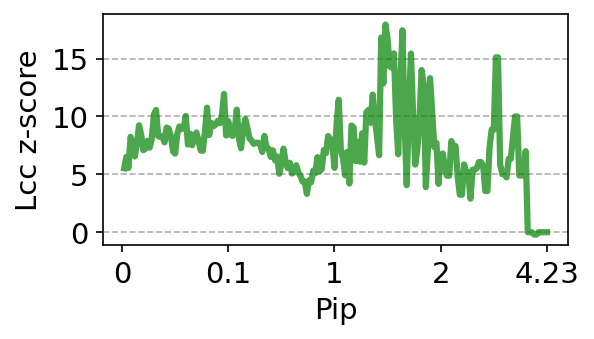

In [97]:
import seaborn as sns
plt.figure(figsize = (4,2),dpi = 150)
# plt.title("Asthma-scRNA")
my_x_ticks = [0,50,100,150,200]
new_x_ticks = [4.23,2,1,0.1,0]
plt.xticks(my_x_ticks,new_x_ticks)
sns.lineplot(data = sampled_data,x = 'x',y = 'lcczscore',color = 'green',
                  linewidth=3,
                  alpha = 0.7).invert_xaxis()
plt.yticks([0,5,10,15])
plt.ylabel("Lcc z-score")
plt.xlabel("Pip")
plt.grid(axis='y',linestyle='--')

## 3. 单细胞、asthma、网络重合基因的类别组成


In [116]:
sc_trait_network = set(sc_gene) & set(trait_gene) & set(G.nodes)
net = pd.read_csv(r"E:\0_单细胞1\data\network(process_id).txt",sep = "\t")
gene_label = pd.DataFrame(columns=["gene","label"])
gene_label["gene"] = list(net["raid_gene1_name"]) + list(net["raid_gene2_name"])
gene_label["label"] = list(net["gene1_class"]) + list(net["gene2_class"])
gene_label = gene_label.drop_duplicates()
sc_trait_network_gene_label = gene_label[gene_label["gene"].isin(sc_trait_network)]
sc_trait_network_gene_label.groupby("label")["gene"].count()

label
lncRNA, antisense            19
lncRNA, divergent           124
lncRNA, intergenic          169
lncRNA, sense intronic       12
protein coding mRNAs      10040
pseudogenes                 139
sense overlap RNAs            1
short ncRNAs                  8
small RNAs                   95
Name: gene, dtype: int64

In [ ]:

### 背景网络的描述

In [23]:
from collections import Counter, defaultdict
import pandas as pd

# 读取文件并统计类别数量和相互作用数量
def analyze_gene_classes(file_path):
    gene_class_counter = Counter()
    interaction_counter = defaultdict(int)

    # 用于去重的集合
    unique_genes = set()

    # 读取文件
    with open(file_path, 'r') as f:
        for line in f:
            # 跳过表头
            if line.startswith("raid_gene1_name"):
                continue

            # 分割每行数据
            columns = line.strip().split('\t')
            if len(columns) != 6:
                continue

            gene1_name = columns[0]
            gene1_class = columns[2]
            gene2_name = columns[3]
            gene2_class = columns[5]

            # 确保基因唯一性
            if gene1_name not in unique_genes:
                gene_class_counter[gene1_class] += 1
                unique_genes.add(gene1_name)
            if gene2_name not in unique_genes:
                gene_class_counter[gene2_class] += 1
                unique_genes.add(gene2_name)
                
                        # 重定义类别
            gene1_class = "coding genes" if gene1_class == "protein coding mRNAs" else "non coding genes"
            gene2_class =  "coding genes" if gene2_class == "protein coding mRNAs" else "non coding genes"

            # 统计类别之间的相互作用
            interaction_counter[(gene1_class, gene2_class)] += 1

    # 输出统计结果
    print("Gene1 Class Count:")
    for gene_class, count in gene_class_counter.items():
        print(f"{gene_class}: {count}")

    print("\nInteractions Between Classes:")
    for (class1, class2), count in interaction_counter.items():
        print(f"{class1} -> {class2}: {count}")

    # 转为DataFrame方便后续分析
    gene1_class_df = pd.DataFrame(gene_class_counter.items(), columns=["Gene_Class", "Count"])
    interaction_df = pd.DataFrame(
        [(*k, v) for k, v in interaction_counter.items()], 
        columns=["Gene1_Class", "Gene2_Class", "Interaction_Count"]
    )

    return gene1_class_df, interaction_df

# 文件路径
file_path = r"..\data\network(process_id).txt"  # 替换为你的文件路径

# 调用函数并获取统计结果
gene1_class_df, interaction_df = analyze_gene_classes(file_path)

# # 将统计结果保存为 CSV 文件
# gene1_class_df.to_csv("gene1_class_count.csv", index=False)
# interaction_df.to_csv("interaction_count.csv", index=False)


Gene1 Class Count:
protein coding mRNAs: 18489
small RNAs: 1745
lncRNA, divergent: 1029
pseudogenes: 671
lncRNA, intergenic: 1884
lncRNA, sense intronic: 135
lncRNA, antisense: 216
short ncRNAs: 20
sense overlap RNAs: 22
structural RNAs: 4

Interactions Between Classes:
coding genes -> coding genes: 275051
non coding genes -> non coding genes: 3542
coding genes -> non coding genes: 13192
non coding genes -> coding genes: 22963


In [32]:
gene1_class_df.index = gene1_class_df["Gene_Class"]
# 使用 reindex() 方法按照指定顺序排列索引
order = ["protein coding mRNAs", "lncRNA, intergenic","lncRNA, divergent","lncRNA, antisense","lncRNA, sense intronic","sense overlap RNAs",
         "small RNAs","short ncRNAs","pseudogenes","structural RNAs"]
gene1_class_df_index = gene1_class_df.reindex(order)

In [33]:
gene1_class_df_index["labels"] = ["coding mRNAs", "lncRNA","lncRNA","lncRNA","lncRNA","lncRNA",
         "miRNAs","miRNAs","pseudogenes","structural RNAs"]
gene1_class_df_index["基因类别"] = ["编码mRNA", "长非编码RNA","长非编码RNA","长非编码RNA","长非编码RNA","长非编码RNA",
         "小分子RNA","小分子RNA","假基因","结构RNA"]
gene1_class_df_index["基因子类别"] = ["编码mRNA", "基因间区lncRNA","反向lncRNA","反义lncRNA","内含子lncRNA","有义重叠lncRNA",
         "小分子RNA","短非编码RNA","假基因","结构RNA"]

([<matplotlib.patches.Wedge at 0x159dae15e20>,
 [Text(-0.06086074691831691, 0.6973492449874342, '假基因'),
  Text(-0.27458654909357094, 0.6438961306428886, '小分子RNA'),
  Text(-0.41387045813954676, 0.5645451654910895, '结构RNA'),
  Text(-0.07667632050870432, -0.6957878569458125, '编码mRNA'),
  Text(0.28946428604931057, 0.6373463949077949, '长非编码RNA')])

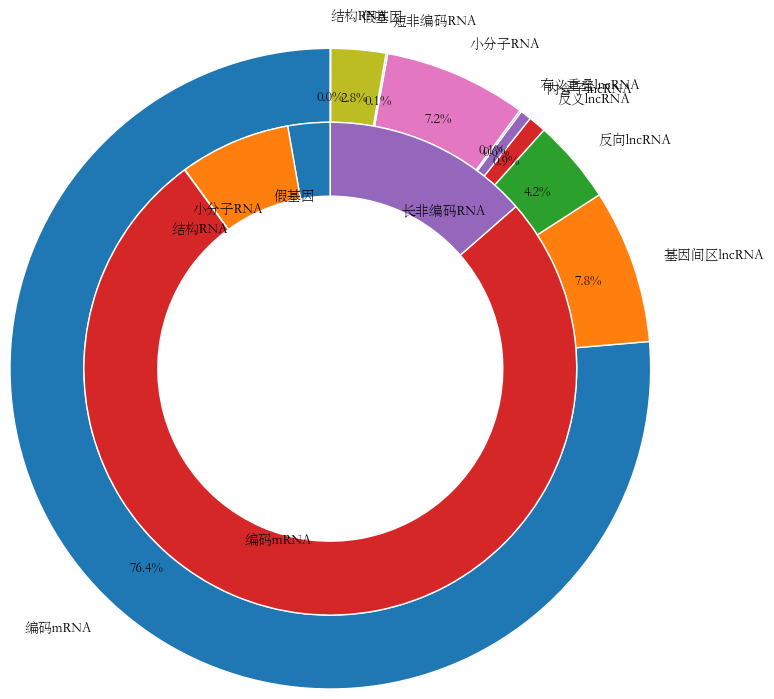

In [46]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置中文字体
rcParams['font.sans-serif'] = ['STSong']  # 使用黑体字体显示中文
rcParams['axes.unicode_minus'] = False   # 解决负号显示问题
# 按基因子类别统计 Count 总和并绘制饼图
inner_data = gene1_class_df_index.groupby("基因类别")["Count"].sum()

# 外层数据（每个月）
outer_labels = gene1_class_df_index["基因子类别"]
outer_sizes = gene1_class_df_index["Count"]

# 内层数据（季度）
inner_labels = inner_data.index
inner_sizes = inner_data.values

# 绘制饼图
fig, ax = plt.subplots(figsize=(8, 8))

# 外层饼图
wedges, texts, autotexts = ax.pie(
    outer_sizes,
    radius=1.3,
    labels=outer_labels,
    autopct=lambda pct: f'{pct:.1f}%',
    pctdistance=0.85,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='white'),
    textprops=dict(color="black")
)

# 内层饼图
ax.pie(
    inner_sizes,
    radius=1,
    labels=inner_labels,
    labeldistance=0.7,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='white'),
    textprops=dict(color="black")
)

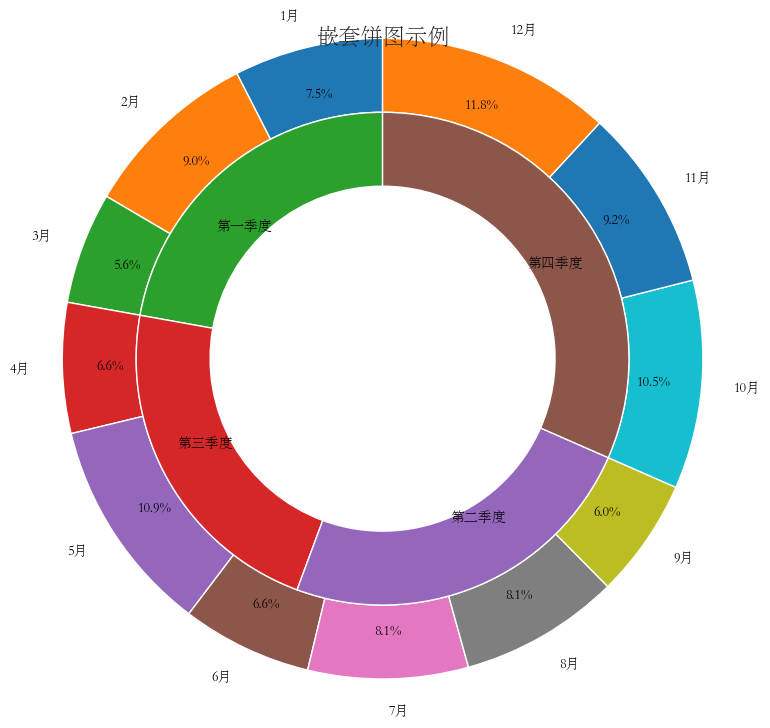

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# 示例 DataFrame 数据
data = {
    "类别名称": ['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月'],
    "Count": [40, 48, 30, 35, 58, 35, 43, 43, 32, 56, 49, 63],
    "季度": ['第一季度', '第一季度', '第一季度',
           '第二季度', '第二季度', '第二季度',
           '第三季度', '第三季度', '第三季度',
           '第四季度', '第四季度', '第四季度']
}

# 构造 DataFrame
df = pd.DataFrame(data)

# 按季度汇总数据
inner_data = df.groupby("季度")["Count"].sum()

# 外层数据（每个月）
outer_labels = df["类别名称"]
outer_sizes = df["Count"]

# 内层数据（季度）
inner_labels = inner_data.index
inner_sizes = inner_data.values

# 绘制饼图
fig, ax = plt.subplots(figsize=(8, 8))

# 外层饼图
wedges, texts, autotexts = ax.pie(
    outer_sizes,
    radius=1.3,
    labels=outer_labels,
    autopct=lambda pct: f'{pct:.1f}%',
    pctdistance=0.85,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='white'),
    textprops=dict(color="black")
)

# 内层饼图
ax.pie(
    inner_sizes,
    radius=1,
    labels=inner_labels,
    labeldistance=0.7,
    startangle=90,
    wedgeprops=dict(width=0.3, edgecolor='white'),
    textprops=dict(color="black")
)

# 设置标题
plt.title("嵌套饼图示例", fontsize=16)

# 显示图像
plt.show()
